In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Can slow down but ensures determinism

set_seed(42)

import json
import matplotlib.pyplot as plt

from mobilenet import MobileNet
from data import get_train_valid_loader, get_test_loader

In [7]:
def train_func(model, optimizer, criterion, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    return train_loss, train_accuracy

def eval(model, criterion, test_loader, device):
    # Evaluate the model on the validation set
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total

    return valid_loss, valid_accuracy


In [8]:
batch_size = 128
data_dir = './data'
train_loader, valid_loader = get_train_valid_loader(data_dir=data_dir,batch_size=batch_size,augment=True,random_seed=42)
test_loader = get_test_loader(data_dir=data_dir, batch_size=batch_size)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
momentum = 0.9


100%|██████████| 169M/169M [00:41<00:00, 4.03MB/s] 


Running experiment with learning rate: 0.2
Epoch [1/15], Train Loss: 4.1912, Train Acc: 5.43%, Valid Loss: 4.0969, Valid Acc: 6.83%
Epoch [11/15], Train Loss: 2.1914, Train Acc: 40.61%, Valid Loss: 2.2493, Valid Acc: 39.95%
Epoch [15/15], Train Loss: 1.8382, Train Acc: 48.51%, Valid Loss: 2.0587, Valid Acc: 44.80%


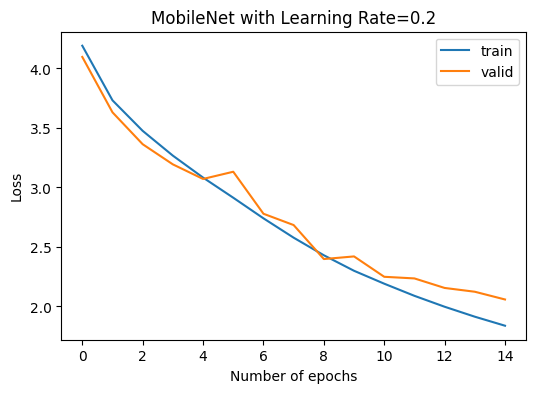

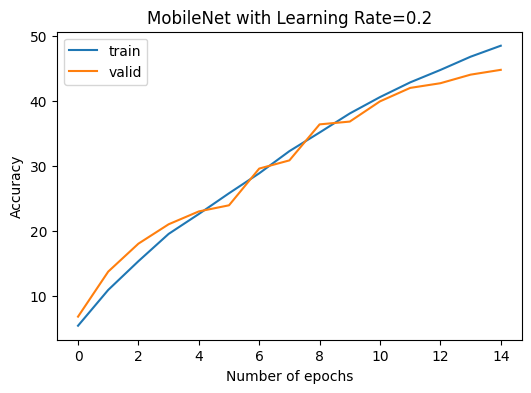

Running experiment with learning rate: 0.05
Epoch [1/15], Train Loss: 4.1467, Train Acc: 6.32%, Valid Loss: 3.8170, Valid Acc: 9.60%
Epoch [11/15], Train Loss: 2.1014, Train Acc: 42.68%, Valid Loss: 2.3139, Valid Acc: 39.18%
Epoch [15/15], Train Loss: 1.7616, Train Acc: 50.48%, Valid Loss: 2.0420, Valid Acc: 46.04%


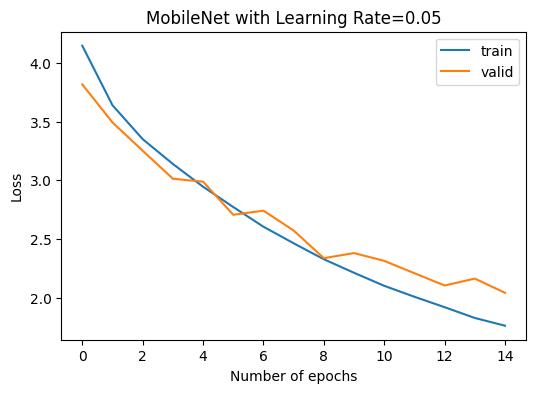

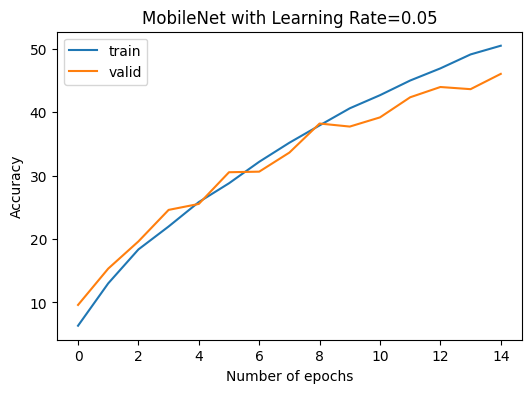

Running experiment with learning rate: 0.01
Epoch [1/15], Train Loss: 4.2954, Train Acc: 4.49%, Valid Loss: 3.9446, Valid Acc: 8.37%


In [ ]:
# prompt:  Run three experiments with the learning rate set to 0.2, 0.05, and 0.01 respectively. The batch size should be set to 128.  Train the networks for 15 epochs under
# each setting.  You should draw the following diagrams: (1) training loss and validation loss against the number of epochs, and (2) training accuracy and validation accuracy against the number of epochs.


# Hyperparameters
num_epochs = 15
learning_rates = [0.2, 0.05, 0.01]


for learning_rate in learning_rates:
    print(f"Running experiment with learning rate: {learning_rate}")
    # MobileNet model
    model = MobileNet(num_classes=100, sigmoid_block_ind = []).to(device)
    # Loss and optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate the model on the validation set
        valid_loss, valid_accuracy = eval(model, criterion, test_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        if epoch % 10 == 0 or epoch == num_epochs-1:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Train Loss: {train_loss:.4f}, "
                f"Train Acc: {train_accuracy:.2f}%, "
                f"Valid Loss: {valid_loss:.4f}, "
                f"Valid Acc: {valid_accuracy:.2f}%")

    # plt.tight_layout()
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(valid_losses)), valid_losses)
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.title(f"MobileNet with Learning Rate={learning_rate}")
    plt.legend(['train', 'valid'])
    plt.savefig(f'images/{learning_rate}_loss.png')
    plt.show()


    plt.figure(figsize=(6, 4))
    plt.plot(range(len(train_accuracies)), train_accuracies)
    plt.plot(range(len(valid_accuracies)), valid_accuracies)
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.title(f"MobileNet with Learning Rate={learning_rate}")
    plt.legend(['train', 'valid'])
    plt.savefig(f'images/{learning_rate}_accuracy.png')
    plt.show()

    learning_curves = {"train_losses": train_losses,
                        "valid_losses": valid_losses,
                        "train_accuracies": train_accuracies,
                        "valid_accuracies": valid_accuracies
                        }
    
    with open(f'learning_curves/{learning_rate}.json', 'w') as fp:
        json.dump(learning_curves, fp)

In [10]:
!git add .
!git commit -m "Auto-commit after learning rate experiment"
!git push origin main  # Change "main" to your branch name

[main 7c93837] Auto-commit after learning rate experiment
 10 files changed, 120 insertions(+), 18 deletions(-)
 create mode 100644 images/0.01_accuracy.png
 create mode 100644 images/0.01_loss.png
 create mode 100644 images/0.05_accuracy.png
 create mode 100644 images/0.05_loss.png
 rewrite images/0.2_accuracy.png (99%)
 rewrite images/0.2_loss.png (99%)
 rewrite learning_curves/0.01.json (100%)
 rewrite learning_curves/0.05.json (100%)
 rewrite learning_curves/0.2.json (100%)
Enumerating objects: 22, done.
Counting objects: 100% (22/22), done.
Delta compression using up to 128 threads
Compressing objects: 100% (14/14), done.
Writing objects: 100% (14/14), 328.92 KiB | 5.67 MiB/s, done.
Total 14 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To github.com:giangson19/ai6103_assignment.git
   9ffe110..7c93837  main -> main


Experiment 1: Training with constant learning rate
Epoch [1/300], Train Loss: 4.1479, Train Acc: 6.60%, Valid Loss: 3.7777, Valid Acc: 11.13%
Epoch [11/300], Train Loss: 2.0787, Train Acc: 42.90%, Valid Loss: 2.2748, Valid Acc: 40.69%
Epoch [21/300], Train Loss: 1.3309, Train Acc: 60.78%, Valid Loss: 1.9736, Valid Acc: 49.45%
Epoch [31/300], Train Loss: 0.8217, Train Acc: 74.22%, Valid Loss: 2.0406, Valid Acc: 52.48%
Epoch [41/300], Train Loss: 0.4364, Train Acc: 85.74%, Valid Loss: 2.2959, Valid Acc: 53.64%
Epoch [51/300], Train Loss: 0.2359, Train Acc: 92.41%, Valid Loss: 2.6146, Valid Acc: 53.70%
Epoch [61/300], Train Loss: 0.1513, Train Acc: 95.01%, Valid Loss: 2.7850, Valid Acc: 54.32%
Epoch [71/300], Train Loss: 0.0943, Train Acc: 96.93%, Valid Loss: 2.9237, Valid Acc: 54.64%
Epoch [81/300], Train Loss: 0.0693, Train Acc: 97.75%, Valid Loss: 2.9586, Valid Acc: 54.96%
Epoch [91/300], Train Loss: 0.0466, Train Acc: 98.55%, Valid Loss: 3.0841, Valid Acc: 54.95%
Epoch [101/300], Trai

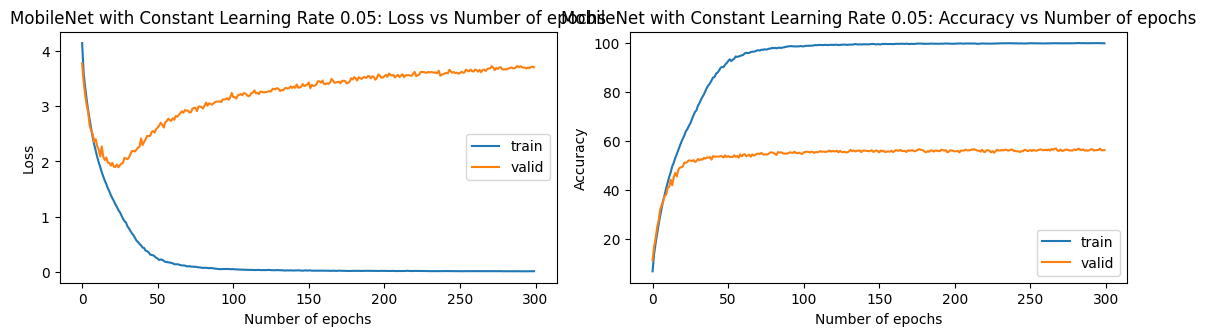

In [10]:
# Hyperparameters for the new experiments
num_epochs = 300
learning_rate = 0.05 # best learning rate from the previous experiment 

# Function to train with constant learning rate
def train_constant_lr(model, optimizer, criterion, train_loader, valid_loader, device, num_epochs):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        valid_loss, valid_accuracy = eval(model, criterion, valid_loader, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        if epoch % 10 == 0 or epoch == num_epochs-1:
        
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, "
                  f"Valid Loss: {valid_loss:.4f}, "
                  f"Valid Acc: {valid_accuracy:.2f}%")

    return train_losses, valid_losses, train_accuracies, valid_accuracies



# Experiment 1: Train for 300 epochs with constant learning rate
print("Experiment 1: Training with constant learning rate")

model = MobileNet(num_classes=100, sigmoid_block_ind = []).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


train_losses, valid_losses, train_accuracies, valid_accuracies = train_constant_lr(
    model, optimizer, criterion, train_loader, valid_loader, device, num_epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title(f"MobileNet with Constant Learning Rate {str(learning_rate)}: Loss vs Number of epochs")
plt.legend(['train', 'valid'])
# plt.savefig('images/constant_lr_loss.png')
# plt.show()

plt.subplot(1, 2, 2)
plt.tight_layout(pad = 3)
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title(f"MobileNet with Constant Learning Rate {str(learning_rate)}: Accuracy vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig(f'images/{learning_rate}_constant_lr_curves.png')
plt.show()


learning_curves = {"train_losses": train_losses,
                    "valid_losses": valid_losses,
                    "train_accuracies": train_accuracies,
                    "valid_accuracies": valid_accuracies
                    }

with open(f'learning_curves/{learning_rate}_constant_lr.json', 'w') as fp:
    json.dump(learning_curves, fp)

In [11]:
!git add .
!git commit -m "Auto-commit after constant learning rate experiment"
!git push origin main  # Change "main" to your branch name

[main c5c57a3] Auto-commit after Jupyter cell
 3 files changed, 78 insertions(+), 361 deletions(-)
 create mode 100644 images/0.05_constant_lr_curves.png
 create mode 100644 learning_curves/0.05_constant_lr.json
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 64 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 58.70 KiB | 4.19 MiB/s, done.
Total 7 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:giangson19/ai6103_assignment.git
   109d94f..c5c57a3  main -> main


Experiment 2: Training with cosine annealing learning rate
Epoch [1/300], Train Loss: 4.1620, Train Acc: 6.16%, Valid Loss: 3.8345, Valid Acc: 10.03%, Learning Rate: 0.049999
Epoch [11/300], Train Loss: 2.0498, Train Acc: 44.00%, Valid Loss: 2.2163, Valid Acc: 41.76%, Learning Rate: 0.049834
Epoch [21/300], Train Loss: 1.3014, Train Acc: 61.51%, Valid Loss: 1.9428, Valid Acc: 49.96%, Learning Rate: 0.049398
Epoch [31/300], Train Loss: 0.8221, Train Acc: 74.25%, Valid Loss: 2.0076, Valid Acc: 53.61%, Learning Rate: 0.048694
Epoch [41/300], Train Loss: 0.4609, Train Acc: 85.02%, Valid Loss: 2.2883, Valid Acc: 53.87%, Learning Rate: 0.047731
Epoch [51/300], Train Loss: 0.2428, Train Acc: 91.98%, Valid Loss: 2.6002, Valid Acc: 53.16%, Learning Rate: 0.046519
Epoch [61/300], Train Loss: 0.1418, Train Acc: 95.28%, Valid Loss: 2.7138, Valid Acc: 54.44%, Learning Rate: 0.045070
Epoch [71/300], Train Loss: 0.0840, Train Acc: 97.29%, Valid Loss: 2.8686, Valid Acc: 55.36%, Learning Rate: 0.043402

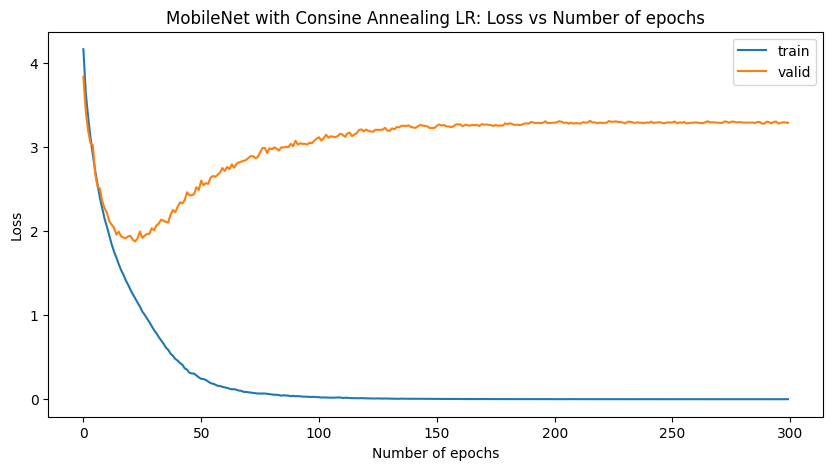

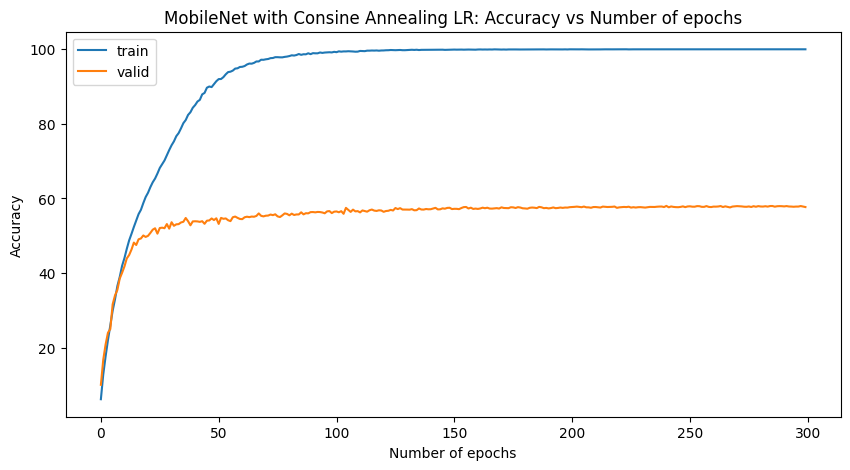

In [15]:
# Function to train with cosine annealing learning rate
def train_cosine_annealing(model, initial_lr, criterion, train_loader, valid_loader, device, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        valid_loss, valid_accuracy = eval(model, criterion, valid_loader, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Extract current learning rate
        if epoch % 10 == 0 or epoch == num_epochs-1:
            
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, "
                  f"Valid Loss: {valid_loss:.4f}, "
                  f"Valid Acc: {valid_accuracy:.2f}%, "
                  f"Learning Rate: {current_lr:.6f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies
    
# Experiment 2: Train for 300 epochs with cosine annealing learning rate
print("Experiment 2: Training with cosine annealing learning rate")

model = MobileNet(num_classes=100, sigmoid_block_ind = []).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

train_losses, valid_losses, train_accuracies, valid_accuracies = train_cosine_annealing(
    model, learning_rate, criterion, train_loader, valid_loader, device, num_epochs)

plt.figure(figsize=(6, 4))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("MobileNet with Consine Annealing LR: Loss vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/cosine_annealing_loss.png')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("MobileNet with Consine Annealing LR: Accuracy vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/cosine_annealing_accuracy.png')
plt.show()


learning_curves = {"train_losses": train_losses,
                    "valid_losses": valid_losses,
                    "train_accuracies": train_accuracies,
                    "valid_accuracies": valid_accuracies
                    }

with open(f'learning_curves/cosine_annealing.json', 'w') as fp:
    json.dump(learning_curves, fp)

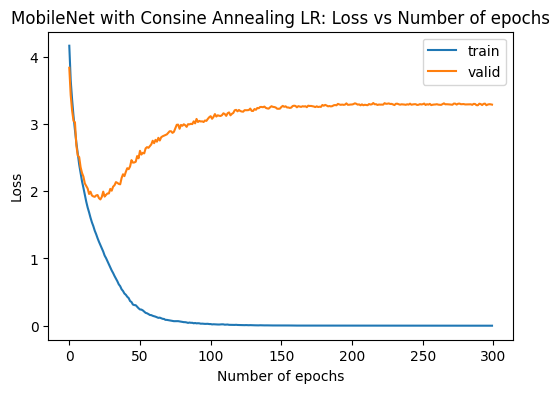

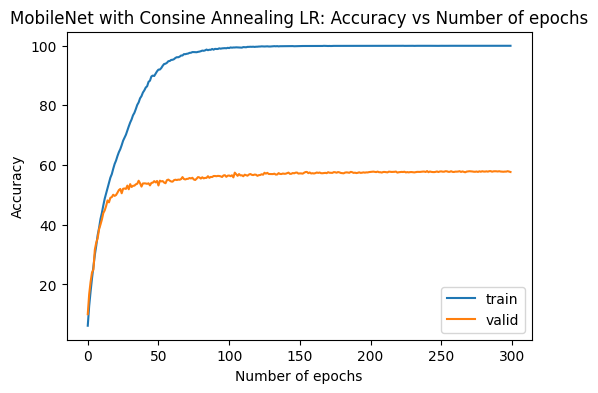

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("MobileNet with Consine Annealing LR: Loss vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/cosine_annealing_loss.png')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("MobileNet with Consine Annealing LR: Accuracy vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/cosine_annealing_accuracy.png')
plt.show()


learning_curves = {"train_losses": train_losses,
                    "valid_losses": valid_losses,
                    "train_accuracies": train_accuracies,
                    "valid_accuracies": valid_accuracies
                    }

In [18]:
!git add .
!git commit -m "Auto-commit after Consine Annealing experiment"
!git push origin main  # Change "main" to your branch name

[main 7015346] Auto-commit after Consine Annealing experiment
 4 files changed, 74 insertions(+), 6 deletions(-)
 create mode 100644 images/cosine_annealing_accuracy.png
 delete mode 100644 images/cosine_annealing_curves.png
 create mode 100644 images/cosine_annealing_loss.png
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 64 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 126.51 KiB | 6.33 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:giangson19/ai6103_assignment.git
   08a4158..7015346  main -> main


In [13]:
# Hyperparameters for the new experiment
num_epochs = 300
learning_rate = 0.01
weight_decay = 1e-4
momentum = 0.9

# Function to train with weight decay and cosine annealing learning rate
def train_weight_decay_cosine_annealing(model, initial_lr, weight_decay, criterion, train_loader, valid_loader, device, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        valid_loss, valid_accuracy = eval(model, criterion, valid_loader, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Extract current learning rate
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Valid Loss: {valid_loss:.4f}, "
              f"Valid Acc: {valid_accuracy:.2f}%, "
              f"Learning Rate: {current_lr:.6f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies
    
# Experiment: Train for 300 epochs with weight decay and cosine annealing learning rate
print("Experiment: Training with weight decay and cosine annealing learning rate")
# MobileNet model
model = MobileNet(num_classes=100).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
train_losses, valid_losses, train_accuracies, valid_accuracies = train_weight_decay_cosine_annealing(
    model, learning_rate, weight_decay, criterion, train_loader, valid_loader, device, num_epochs)

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("MobileNet with Weight Decay and Cosine Annealing LR: Loss vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/weight_decay_cosine_annealing_loss_1e4.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("MobileNet with Weight Decay and Cosine Annealing LR: Accuracy vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/weight_decay_cosine_annealing_accuracy_1e4.png')
plt.show()


learning_curves_cosine_annealing_weight_decay = {"train_losses": train_losses,
                                "valid_losses": valid_losses,
                                "train_accuracies": train_accuracies,
                                "valid_accuracies": valid_accuracies
                                    }
with open('learning_curves_cosine_annealing_weight_decay_1e4.json', 'w') as fp:
    json.dump(learning_curves_cosine_annealing, fp)

Experiment: Training with weight decay and cosine annealing learning rate
Epoch [1/300], Train Loss: 4.1297, Train Acc: 6.10%, Valid Loss: 3.7001, Valid Acc: 11.60%, Learning Rate: 0.010000
Epoch [2/300], Train Loss: 3.4975, Train Acc: 15.48%, Valid Loss: 3.3249, Valid Acc: 18.08%, Learning Rate: 0.009999
Epoch [3/300], Train Loss: 3.1565, Train Acc: 21.62%, Valid Loss: 2.9490, Valid Acc: 25.96%, Learning Rate: 0.009998
Epoch [4/300], Train Loss: 2.8999, Train Acc: 26.32%, Valid Loss: 2.7711, Valid Acc: 28.50%, Learning Rate: 0.009996
Epoch [5/300], Train Loss: 2.6819, Train Acc: 30.97%, Valid Loss: 2.5647, Valid Acc: 33.01%, Learning Rate: 0.009993
Epoch [6/300], Train Loss: 2.5128, Train Acc: 34.26%, Valid Loss: 2.4745, Valid Acc: 35.59%, Learning Rate: 0.009990
Epoch [7/300], Train Loss: 2.3715, Train Acc: 37.08%, Valid Loss: 2.3131, Valid Acc: 39.01%, Learning Rate: 0.009987
Epoch [8/300], Train Loss: 2.2430, Train Acc: 40.05%, Valid Loss: 2.2293, Valid Acc: 40.69%, Learning Rate: 

Exception ignored in: <function _releaseLock at 0x7f4d37fb2cb0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 7622, 7623) exited unexpectedly

In [ ]:
def test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy on the test set
test_acc = test_accuracy(model, test_loader, device)
print(f"Accuracy of the model on the hold-out test set: {test_acc:.2f}%")